In [1]:
import os 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt

seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)
torch.backends.cudnn.deterministic = True
excel_path = r"D:\我的论文\河流水化学组成的时空变化特征及其影响因素的研究\data\离子浓度.xlsx"
df = pd.read_excel(excel_path, sheet_name=0)
mask = df.loc[:, '流域边长 km': ].columns
mask = ['重碳酸根离子(HCO3- ) mg/L'] + list(mask)
df = df.loc[:, mask]
# 查看df是否存在空值
null_values = df.isnull()
null_counts = null_values.sum()

#使用多项式插值补充缺失值

df_interpolate = df.interpolate(method='polynomial', order=5, axis=0)

# 查看df_interpolate是否存在空值
null_values = df_interpolate.isnull()
null_counts = null_values.sum()

Epoch [100/1000], RMSE Loss: 0.1727, Validation Loss: 0.1824
Epoch [200/1000], RMSE Loss: 0.1566, Validation Loss: 0.1676
Epoch [300/1000], RMSE Loss: 0.1432, Validation Loss: 0.1555
Epoch [400/1000], RMSE Loss: 0.1321, Validation Loss: 0.1456
Epoch [500/1000], RMSE Loss: 0.1228, Validation Loss: 0.1376
Epoch [600/1000], RMSE Loss: 0.1153, Validation Loss: 0.1311
Epoch [700/1000], RMSE Loss: 0.1090, Validation Loss: 0.1259
Epoch [800/1000], RMSE Loss: 0.1040, Validation Loss: 0.1217
Epoch [900/1000], RMSE Loss: 0.0998, Validation Loss: 0.1184
Epoch [1000/1000], RMSE Loss: 0.0965, Validation Loss: 0.1158
Epoch [100/1000], RMSE Loss: 0.1892, Validation Loss: 0.1878
Epoch [200/1000], RMSE Loss: 0.1705, Validation Loss: 0.1697
Epoch [300/1000], RMSE Loss: 0.1549, Validation Loss: 0.1547
Epoch [400/1000], RMSE Loss: 0.1420, Validation Loss: 0.1424
Epoch [500/1000], RMSE Loss: 0.1313, Validation Loss: 0.1323
Epoch [600/1000], RMSE Loss: 0.1226, Validation Loss: 0.1242
Epoch [700/1000], RMSE 

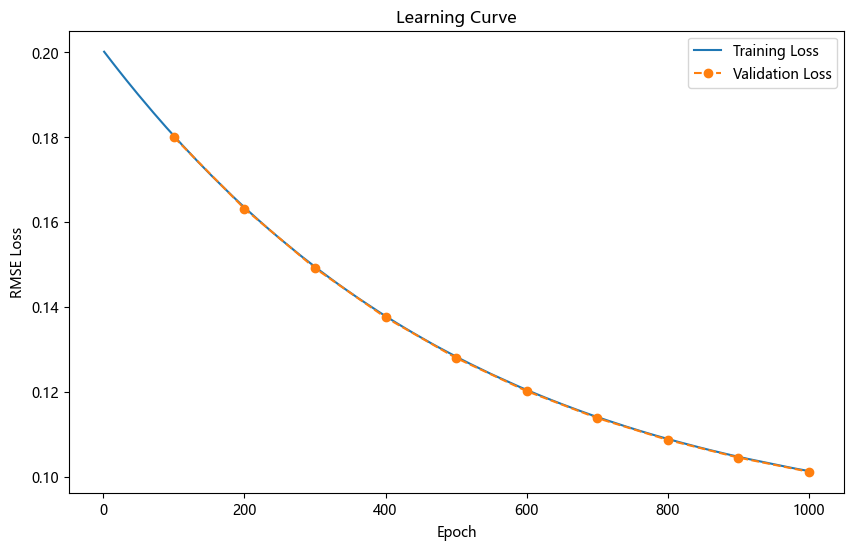

In [2]:
## 使用了dropout

class FNN(nn.Module):
    """定义FNN前馈神经网络"""
    def __init__(self ,input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        """初始化属性"""
        super(FNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(dropout_rate)

        init.normal_(self.layer1.weight, mean=0, std=0.01)
        init.normal_(self.layer2.weight, mean=0, std=0.01)
        init.normal_(self.output_layer.weight, mean=0, std=0.01)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x


# 特征和标签
x = df_interpolate.drop('重碳酸根离子(HCO3- ) mg/L', axis=1).values
t = df_interpolate['重碳酸根离子(HCO3- ) mg/L'].values.reshape(-1, 1)

# 数据标准化
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
t_scaled = scaler.fit_transform(t)
# 划分训练集和测试集
x_train, x_test, t_train, t_test = train_test_split(x_scaled, t_scaled, test_size=0.2, random_state=seed_value)
# 交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=seed_value)
all_train_losses = []
all_test_losses = []

for train_index, test_index in kf.split(x_train):
    x_fold_train, x_fold_test = x_train[train_index], x_train[test_index]
    t_fold_train, t_fold_test = t_train[train_index], t_train[test_index]

    x_train_tensor = torch.FloatTensor(x_fold_train)
    t_train_tensor = torch.FloatTensor(t_fold_train).view(-1, 1) 
    x_test_tensor = torch.FloatTensor(x_fold_test)
    t_test_tensor = torch.FloatTensor(t_fold_test).view(-1, 1)

    # 初始化模型和优化器
    input_size = x_fold_train.shape[1]
    hidden_size1 = 100
    hidden_size2 = 50
    output_size = 1
    model = FNN(input_size, hidden_size1, hidden_size2, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_losses = []
    test_losses = []

    # 训练模型
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, t_train_tensor)
        loss.backward()
        optimizer.step()

        train_losses.append(torch.sqrt(loss).item())
        if (epoch + 1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                test_outputs = model(x_test_tensor)
                test_loss = criterion(test_outputs, t_test_tensor) 
                test_losses.append(test_loss.item())
            print(f'Epoch [{epoch+1}/{num_epochs}], RMSE Loss: {torch.sqrt(loss).item():.4f}, Validation Loss: {torch.sqrt(test_loss).item():.4f}')
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)
        
avg_train_losses = np.mean(all_train_losses, axis=0)
avg_test_losses = np.mean(all_test_losses, axis=0)
    
# 绘制学习曲线
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), avg_train_losses, label='Training Loss')
plt.plot(range(100, num_epochs+1, 100), torch.sqrt(torch.tensor(avg_test_losses)), label='Validation Loss', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


Epoch [100/1000], RMSE Loss: 0.1849, Validation Loss: 0.1934
Epoch [200/1000], RMSE Loss: 0.1430, Validation Loss: 0.1550
Epoch [300/1000], RMSE Loss: 0.1148, Validation Loss: 0.1305
Epoch [400/1000], RMSE Loss: 0.0980, Validation Loss: 0.1170
Epoch [500/1000], RMSE Loss: 0.0893, Validation Loss: 0.1105
Epoch [600/1000], RMSE Loss: 0.0852, Validation Loss: 0.1076
Epoch [700/1000], RMSE Loss: 0.0832, Validation Loss: 0.1064
Epoch [800/1000], RMSE Loss: 0.0823, Validation Loss: 0.1058
Epoch [900/1000], RMSE Loss: 0.0819, Validation Loss: 0.1056
Epoch [1000/1000], RMSE Loss: 0.0816, Validation Loss: 0.1054
Epoch [100/1000], RMSE Loss: 0.2033, Validation Loss: 0.2018
Epoch [200/1000], RMSE Loss: 0.1654, Validation Loss: 0.1653
Epoch [300/1000], RMSE Loss: 0.1363, Validation Loss: 0.1379
Epoch [400/1000], RMSE Loss: 0.1157, Validation Loss: 0.1190
Epoch [500/1000], RMSE Loss: 0.1026, Validation Loss: 0.1074
Epoch [600/1000], RMSE Loss: 0.0949, Validation Loss: 0.1009
Epoch [700/1000], RMSE 

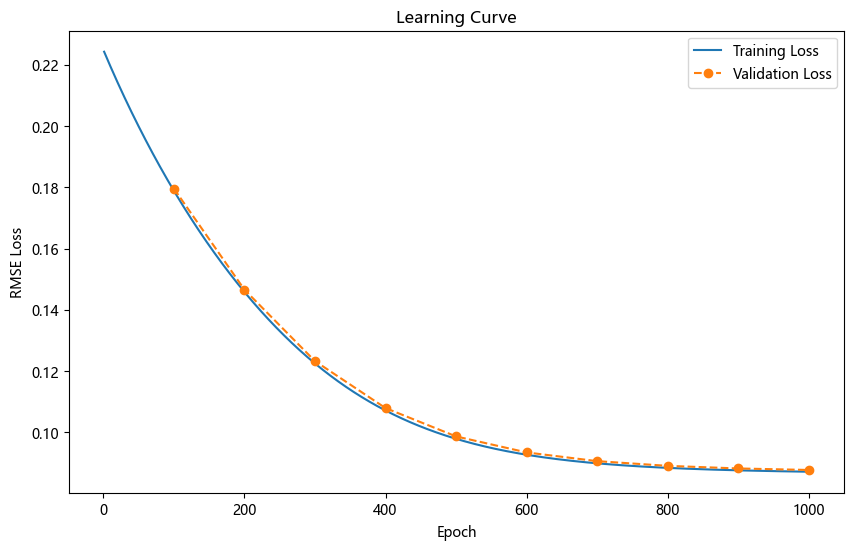

In [3]:
## 使用了权重衰减

class FNN(nn.Module):
    """定义FNN前馈神经网络"""
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        """初始化属性"""
        super(FNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

# 特征和标签
x = df_interpolate.drop('重碳酸根离子(HCO3- ) mg/L', axis=1).values
t = df_interpolate['重碳酸根离子(HCO3- ) mg/L'].values.reshape(-1, 1)

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
t_scaled = scaler.fit_transform(t)
# 划分训练集和测试集
x_train, x_test, t_train, t_test = train_test_split(x_scaled, t_scaled, test_size=0.2, random_state=seed_value)
# 交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=seed_value)
all_train_losses = []
all_test_losses = []

for train_index, test_index in kf.split(x_train):
    x_fold_train, x_fold_test = x_train[train_index], x_train[test_index]
    t_fold_train, t_fold_test = t_train[train_index], t_train[test_index]

    x_train_tensor = torch.FloatTensor(x_fold_train)
    t_train_tensor = torch.FloatTensor(t_fold_train).view(-1, 1)
    x_test_tensor = torch.FloatTensor(x_fold_test)
    t_test_tensor = torch.FloatTensor(t_fold_test).view(-1, 1)

    # 初始化模型和优化器
    input_size = x_fold_train.shape[1]
    hidden_size1 = 100
    hidden_size2 = 50
    output_size = 1
    model = FNN(input_size, hidden_size1, hidden_size2, output_size)
    criterion = nn.MSELoss()
    
    # 使用权重衰减
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

    train_losses = []
    test_losses = []

    # 训练模型
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, t_train_tensor)
        loss.backward()
        optimizer.step()

        train_losses.append(torch.sqrt(loss).item())
        if (epoch + 1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                test_outputs = model(x_test_tensor)
                test_loss = criterion(test_outputs, t_test_tensor) 
                test_losses.append(test_loss.item())
            print(f'Epoch [{epoch+1}/{num_epochs}], RMSE Loss: {torch.sqrt(loss).item():.4f}, Validation Loss: {torch.sqrt(test_loss).item():.4f}')
    
    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)

avg_train_losses = np.mean(all_train_losses, axis=0)
avg_test_losses = np.mean(all_test_losses, axis=0)

# 绘制学习曲线
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), avg_train_losses, label='Training Loss')
plt.plot(range(100, num_epochs+1, 100), torch.sqrt(torch.tensor(avg_test_losses)), label='Validation Loss', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


Epoch [100/1000], RMSE Loss: 0.1733, Validation Loss: 0.1829
Epoch [200/1000], RMSE Loss: 0.1566, Validation Loss: 0.1675
Epoch [300/1000], RMSE Loss: 0.1427, Validation Loss: 0.1550
Epoch [400/1000], RMSE Loss: 0.1312, Validation Loss: 0.1448
Epoch [500/1000], RMSE Loss: 0.1218, Validation Loss: 0.1367
Epoch [600/1000], RMSE Loss: 0.1142, Validation Loss: 0.1301
Epoch [700/1000], RMSE Loss: 0.1079, Validation Loss: 0.1250
Epoch [800/1000], RMSE Loss: 0.1029, Validation Loss: 0.1208
Epoch [900/1000], RMSE Loss: 0.0988, Validation Loss: 0.1176
Epoch [1000/1000], RMSE Loss: 0.0956, Validation Loss: 0.1151
Epoch [100/1000], RMSE Loss: 0.2068, Validation Loss: 0.2050
Epoch [200/1000], RMSE Loss: 0.1851, Validation Loss: 0.1839
Epoch [300/1000], RMSE Loss: 0.1668, Validation Loss: 0.1662
Epoch [400/1000], RMSE Loss: 0.1516, Validation Loss: 0.1516
Epoch [500/1000], RMSE Loss: 0.1390, Validation Loss: 0.1396
Epoch [600/1000], RMSE Loss: 0.1286, Validation Loss: 0.1298
Epoch [700/1000], RMSE 

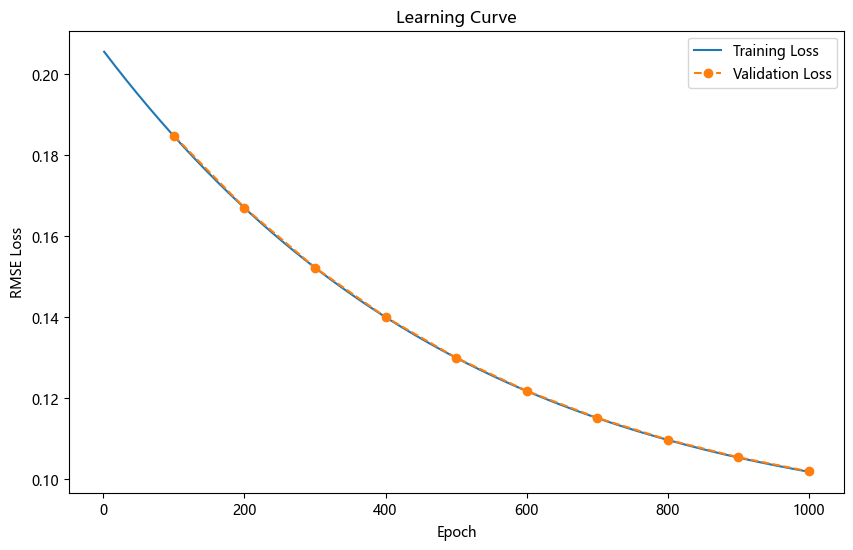

In [4]:
## 使用了权重衰减(权重初始元素取自正态分布)

class FNN(nn.Module):
    """定义FNN前馈神经网络"""
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        """初始化属性"""
        super(FNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, output_size)

        init.normal_(self.layer1.weight, mean=0, std=0.01)
        init.normal_(self.layer2.weight, mean=0, std=0.01)
        init.normal_(self.output_layer.weight, mean=0, std=0.01)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

# 特征和标签
x = df_interpolate.drop('重碳酸根离子(HCO3- ) mg/L', axis=1).values
t = df_interpolate['重碳酸根离子(HCO3- ) mg/L'].values.reshape(-1, 1)

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
t_scaled = scaler.fit_transform(t)

# 划分训练集和测试集
x_train, x_test, t_train, t_test = train_test_split(x_scaled, t_scaled, test_size=0.2, random_state=seed_value)

# 交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=seed_value)
all_train_losses = []
all_test_losses = []

for train_index, test_index in kf.split(x_train):
    x_fold_train, x_fold_test = x_train[train_index], x_train[test_index]
    t_fold_train, t_fold_test = t_train[train_index], t_train[test_index]

    x_train_tensor = torch.FloatTensor(x_fold_train)
    t_train_tensor = torch.FloatTensor(t_fold_train).view(-1, 1)
    x_test_tensor = torch.FloatTensor(x_fold_test)
    t_test_tensor = torch.FloatTensor(t_fold_test).view(-1, 1)

    # 初始化模型和优化器
    input_size = x_fold_train.shape[1]
    hidden_size1 = 100
    hidden_size2 = 50
    output_size = 1
    model = FNN(input_size, hidden_size1, hidden_size2, output_size)
    criterion = nn.MSELoss()
    
    # 使用权重衰减
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

    train_losses = []
    test_losses = []

    # 训练模型
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, t_train_tensor)
        loss.backward()
        optimizer.step()

        train_losses.append(torch.sqrt(loss).item())
        if (epoch + 1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                test_outputs = model(x_test_tensor)
                test_loss = criterion(test_outputs, t_test_tensor) 
                test_losses.append(test_loss.item())
            print(f'Epoch [{epoch+1}/{num_epochs}], RMSE Loss: {torch.sqrt(loss).item():.4f}, Validation Loss: {torch.sqrt(test_loss).item():.4f}')
    
    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)

avg_train_losses = np.mean(all_train_losses, axis=0)
avg_test_losses = np.mean(all_test_losses, axis=0)

# 绘制学习曲线
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), avg_train_losses, label='Training Loss')
plt.plot(range(100, num_epochs+1, 100), torch.sqrt(torch.tensor(avg_test_losses)), label='Validation Loss', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


Epoch [100/1000], RMSE Loss: 0.1932
Epoch [200/1000], RMSE Loss: 0.1633
Epoch [300/1000], RMSE Loss: 0.1391
Epoch [400/1000], RMSE Loss: 0.1207
Epoch [500/1000], RMSE Loss: 0.1077
Epoch [600/1000], RMSE Loss: 0.0992
Epoch [700/1000], RMSE Loss: 0.0940
Epoch [800/1000], RMSE Loss: 0.0909
Epoch [900/1000], RMSE Loss: 0.0892
Epoch [1000/1000], RMSE Loss: 0.0882
Epoch [100/1000], RMSE Loss: 0.2071
Epoch [200/1000], RMSE Loss: 0.1736
Epoch [300/1000], RMSE Loss: 0.1479
Epoch [400/1000], RMSE Loss: 0.1285
Epoch [500/1000], RMSE Loss: 0.1146
Epoch [600/1000], RMSE Loss: 0.1054
Epoch [700/1000], RMSE Loss: 0.0997
Epoch [800/1000], RMSE Loss: 0.0963
Epoch [900/1000], RMSE Loss: 0.0943
Epoch [1000/1000], RMSE Loss: 0.0932
Epoch [100/1000], RMSE Loss: 0.1786
Epoch [200/1000], RMSE Loss: 0.1474
Epoch [300/1000], RMSE Loss: 0.1244
Epoch [400/1000], RMSE Loss: 0.1091
Epoch [500/1000], RMSE Loss: 0.0998
Epoch [600/1000], RMSE Loss: 0.0946
Epoch [700/1000], RMSE Loss: 0.0917
Epoch [800/1000], RMSE Los

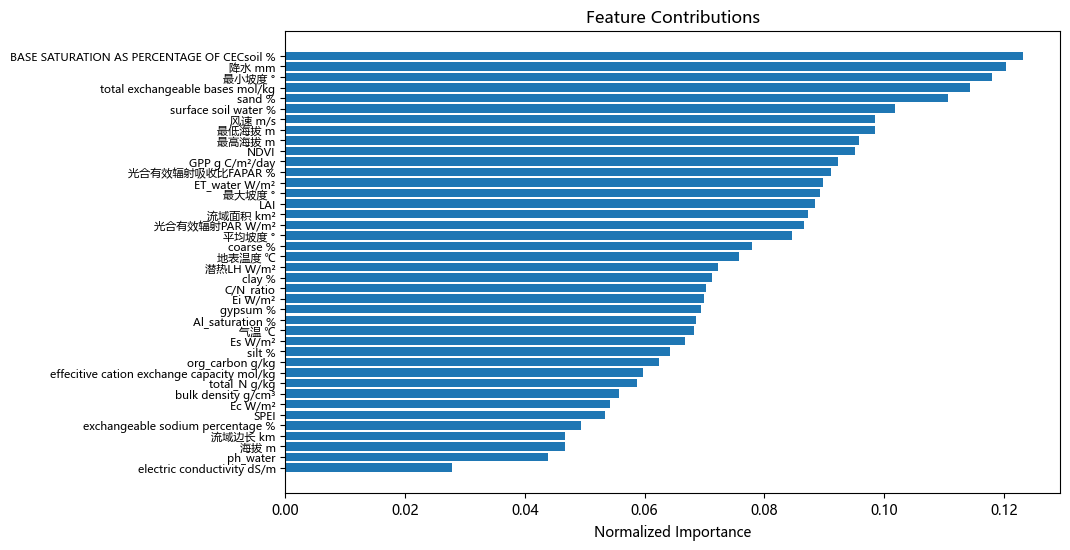

In [3]:
## 权重衰减

class FNN(nn.Module):
    """定义FNN前馈神经网络"""
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        """初始化属性"""
        super(FNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

# 特征和标签
x = df_interpolate.drop('重碳酸根离子(HCO3- ) mg/L', axis=1).values
t = df_interpolate['重碳酸根离子(HCO3- ) mg/L'].values.reshape(-1, 1)

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
t_scaled = scaler.fit_transform(t)
# 划分训练集和测试集
x_train, x_test, t_train, t_test = train_test_split(x_scaled, t_scaled, test_size=0.2, random_state=seed_value)

# 交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=seed_value)
all_importance = np.zeros_like(x[0])

for train_index, test_index in kf.split(x_train):
    x_folder_train, x_folder_test = x_train[train_index], x_train[test_index]
    t_folder_train, t_folder_test = t_train[train_index], t_train[test_index]

    x_train_tensor = torch.FloatTensor(x_fold_train)
    t_train_tensor = torch.FloatTensor(t_fold_train).view(-1, 1)
    x_test_tensor = torch.FloatTensor(x_fold_test)
    t_test_tensor = torch.FloatTensor(t_fold_test).view(-1, 1)

    # 初始化模型和优化器
    input_size = x_fold_train.shape[1]
    hidden_size1 = 100
    hidden_size2 = 50
    output_size = 1
    model = FNN(input_size, hidden_size1, hidden_size2, output_size)
    criterion = nn.MSELoss()
    
    # 使用权重衰减
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

    # 训练模型
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, t_train_tensor)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            rmse_loss = torch.sqrt(loss).item()
            print(f'Epoch [{epoch+1}/{num_epochs}], RMSE Loss: {rmse_loss:.4f}')

    # 评估模型
    model.eval()
    with torch.no_grad():
        predictions = model(x_test_tensor)
        importance = np.abs(model.layer1.weight.detach().numpy())

    all_importance += importance[0]
average_importance = all_importance / kf.get_n_splits()

feature_names = df_interpolate.drop('重碳酸根离子(HCO3- ) mg/L', axis=1).columns.to_list()
sorted_indices = np.argsort(average_importance)[::-1]
print("Feature Contributions: ")
for i, idx in enumerate(sorted_indices):
    print(f'{feature_names[idx]}: {average_importance[idx]}')

# 绘制特征贡献度图
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
plt.figure(figsize=(10, 6))
plt.barh([feature_names[idx] for idx in sorted_indices], [average_importance[idx] for idx in sorted_indices])
plt.xlabel('Normalized Importance')
plt.title('Feature Contributions')
plt.gca().invert_yaxis()
plt.yticks(fontsize=8)
plt.show()


Epoch [100/1000], RMSE Loss: 0.1748
Epoch [200/1000], RMSE Loss: 0.1591
Epoch [300/1000], RMSE Loss: 0.1461
Epoch [400/1000], RMSE Loss: 0.1353
Epoch [500/1000], RMSE Loss: 0.1264
Epoch [600/1000], RMSE Loss: 0.1191
Epoch [700/1000], RMSE Loss: 0.1131
Epoch [800/1000], RMSE Loss: 0.1083
Epoch [900/1000], RMSE Loss: 0.1044
Epoch [1000/1000], RMSE Loss: 0.1012
Epoch [100/1000], RMSE Loss: 0.1871
Epoch [200/1000], RMSE Loss: 0.1696
Epoch [300/1000], RMSE Loss: 0.1551
Epoch [400/1000], RMSE Loss: 0.1432
Epoch [500/1000], RMSE Loss: 0.1334
Epoch [600/1000], RMSE Loss: 0.1255
Epoch [700/1000], RMSE Loss: 0.1190
Epoch [800/1000], RMSE Loss: 0.1138
Epoch [900/1000], RMSE Loss: 0.1096
Epoch [1000/1000], RMSE Loss: 0.1063
Epoch [100/1000], RMSE Loss: 0.2130
Epoch [200/1000], RMSE Loss: 0.1911
Epoch [300/1000], RMSE Loss: 0.1726
Epoch [400/1000], RMSE Loss: 0.1572
Epoch [500/1000], RMSE Loss: 0.1444
Epoch [600/1000], RMSE Loss: 0.1339
Epoch [700/1000], RMSE Loss: 0.1253
Epoch [800/1000], RMSE Los

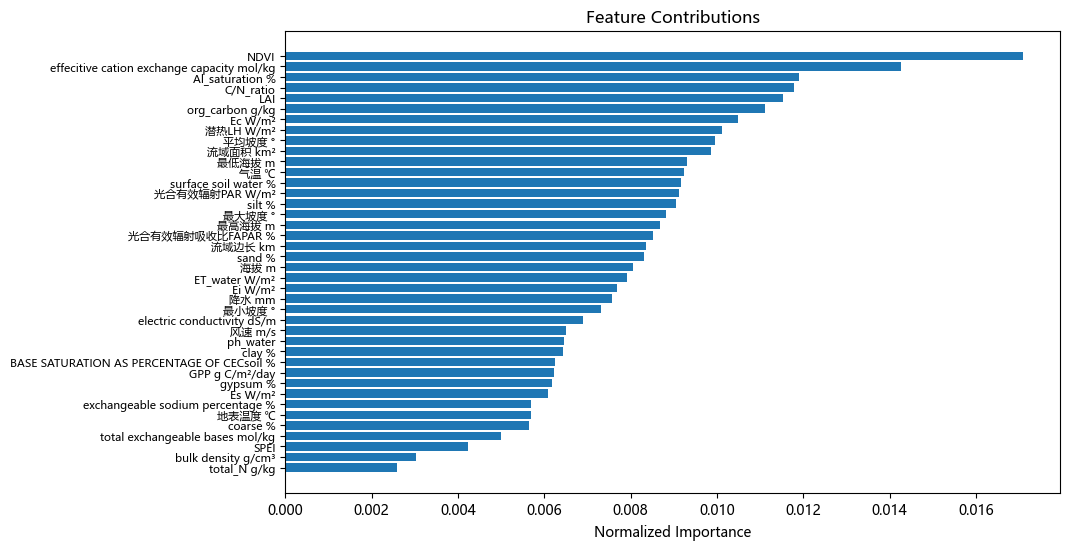

In [2]:
## 权重衰减（权重初始元素取自正态分布）

class FNN(nn.Module):
    """定义FNN前馈神经网络"""
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        """初始化属性"""
        super(FNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, output_size)

        init.normal_(self.layer1.weight, mean=0, std=0.01)
        init.normal_(self.layer2.weight, mean=0, std=0.01)
        init.normal_(self.output_layer.weight, mean=0, std=0.01)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

# 特征和标签
x = df_interpolate.drop('重碳酸根离子(HCO3- ) mg/L', axis=1).values
t = df_interpolate['重碳酸根离子(HCO3- ) mg/L'].values.reshape(-1, 1)

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
t_scaled = scaler.fit_transform(t)

# 交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=seed_value)
all_importance = np.zeros_like(x[0])

for train_index, test_index in kf.split(x_scaled):
    x_folder_train, x_folder_test = x_train[train_index], x_train[test_index]
    t_folder_train, t_folder_test = t_train[train_index], t_train[test_index]

    x_train_tensor = torch.FloatTensor(x_folder_train)
    t_train_tensor = torch.FloatTensor(t_folder_train).view(-1, 1)
    x_test_tensor = torch.FloatTensor(x_folder_test)
    t_test_tensor = torch.FloatTensor(t_folder_test).view(-1, 1)

    # 初始化模型和优化器
    input_size = x_folder_train.shape[1]
    hidden_size1 = 100
    hidden_size2 = 50
    output_size = 1
    model = FNN(input_size, hidden_size1, hidden_size2, output_size)
    criterion = nn.MSELoss()
    
    # 使用权重衰减
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

    # 训练模型
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, t_train_tensor)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            rmse_loss = torch.sqrt(loss).item()
            print(f'Epoch [{epoch+1}/{num_epochs}], RMSE Loss: {rmse_loss:.4f}')

    # 评估模型
    model.eval()
    with torch.no_grad():
        predictions = model(x_test_tensor)
        importance = np.abs(model.layer1.weight.detach().numpy())

    all_importance += importance[0]
average_importance = all_importance / kf.get_n_splits()

feature_names = df_interpolate.drop('重碳酸根离子(HCO3- ) mg/L', axis=1).columns.to_list()
sorted_indices = np.argsort(average_importance)[::-1]
print("Feature Contributions: ")
for i, idx in enumerate(sorted_indices):
    print(f'{feature_names[idx]}: {average_importance[idx]}')

# 绘制特征贡献度图
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
plt.figure(figsize=(10, 6))
plt.barh([feature_names[idx] for idx in sorted_indices], [average_importance[idx] for idx in sorted_indices])
plt.xlabel('Normalized Importance')
plt.title('Feature Contributions')
plt.gca().invert_yaxis()
plt.yticks(fontsize=8)
plt.show()
